In [12]:
# EXPERIMENTAL
# Work in progress (do not use)

# find TC genesis from models based on work similar to FSU's methodology

# only focused on 1. so far:
# [1] https://journals.ametsoc.org/view/journals/wefo/28/6/waf-d-13-00008_1.xml
# [2] https://journals.ametsoc.org/view/journals/wefo/31/3/waf-d-15-0157_1.xml?tab_body=fulltext-display
# [3] https://journals.ametsoc.org/view/journals/wefo/32/1/waf-d-16-0072_1.xml

# units are metric, but scale may be mixed between internal representations of data, thresholds, and printouts

# partial TODO
#    delete old data (ready to delete old data theoretically...
#        recalculate once we get roci, 10m/s max wind, storm ids from box tracking)
#
#    chart disturbances 
#        todo assigning unique storm tracks (moving box method to bin disturbances...?)
#             popup for max wind speed/mslp/roci
#        generate image for image overlay to title the map
#        map.save
#    
#    get max 10m speed if available
#        87:10 metre U wind component:m s**-1 (instant):regular_ll:heightAboveGround:level 10 m:fcst time 96 hrs:from 202310190600
#        88:10 metre V wind component:m s**-1 (instant):regular_ll:heightAboveGround:level 10 m:fcst time 96 hrs:from 202310190600
#        get max 10m speed in neighborhood.. neighborhood of what size? Use (calculate) ROCI or else?
#             for ROCI, closed isobar()-dfs provides visited array that can be used to find ROCI with a large enough neighborhood for each isobar (very slow)
#                 would use for each +1 isobar from .. where? the MSLP minimum or the ~ "mass" center (https://www.sciencedirect.com/science/article/pii/S2225603218300912)
#                 might be more appropriate to use the mass center for roci and compute vmax from each closed iso bar up to roci
#             calculating closed isobars ... need 
#    extend to handle multiple time_steps/bufrs
#        individually a single criteria being met is a disturbance,
#             start of 24 continuous hours of meeting criterias a tc
#    automatically download model files (UKMET seems infeasible as it costs much money)

# thresholds for disturbances (reversed from text output from FSU)
disturbance_thresholds_path = 'disturbance_thresholds.json'

disturbances_db_file_path = 'disturbances.db'

# shape file for placing lat,lon in basins which we are classifying
# each has an attribute called 'basin_name', with CPAC & EPAC combined as EPAC
# basins are NATL, EPAC, WPAC, IO, SH
shape_file = 'shapes/basins.shp'

# for debugging MSLP isobars (depth first search)
debug_isobar_images = False

# save vorticity calculations
debug_save_vorticity = False

# output calculation timing for debugging & optimization
debug_calc_exec_time = True

In [ ]:
# use cgroup (cgroup-tools) to set memory limit as percentage of memory
# add 3 lines to sudoers (use * in place of params), make sure to escape colons

import os
import subprocess
percent_memory_limit = 30
pid = os.getpid()

total_memory = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
memory_limit = int(total_memory * percent_memory_limit / 100)
cg_cmd = "sudo /usr/bin/cgcreate -g memory:mygroup"
subprocess.run(cg_cmd, shell=True)
move_notebook_to_cg_cmd = f"sudo /usr/bin/cgclassify -g memory:mygroup {pid}"
subprocess.run(move_notebook_to_cg_cmd, shell = True)
set_memory_limit_cmd = f"sudo /usr/bin/cgset -r memory.limit_in_bytes={memory_limit} memory:mygroup"
subprocess.run(set_memory_limit_cmd, shell = True)

In [70]:
import json
import pygrib
import re
import math
from metpy.units import units
import metpy.constants as mpconst
import metpy.calc as mpcalc
import numpy as np
import pyproj
import geopandas as gpd
from shapely.geometry import Point

import traceback
import sys
import copy
import time
import os

import warnings

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta
import sqlite3

# for generating charts of disturbances
from IPython.display import display
from ipyleaflet import Map, GeoJSON, LayersControl, Icon, basemaps, basemap_to_tiles, LayerGroup, FullScreenControl, LegendControl, ImageOverlay
from ipywidgets import IntSlider, widgets
from PIL import Image, ImageDraw, ImageFont
import io
import base64

# may need to modify lzma.py in python folder to get this to work (pip install backports-lzma)
# this is for metpy
try:
    import lzma
except ImportError:
    import backports.lzma as lzma

gdf = gpd.read_file(shape_file)

disturbance_criteria_names_map = {
    'WS': 'vmax925',
    'THKN': 'gp250_850_thickness',
    'RV': 'rv850max'
}

# shape file attribute names to threshold names
shape_basin_names_to_threshold_names_map = {
    'NATL': 'AL',
    'WPAC': 'WP',
    'IO': 'IO',
    'SH': 'SH',
    'EPAC': 'EP'
}

# not including GFS analysis files (.anl)
total_model_time_steps = {
    'GFS': {
        '00': 65,
        '06': 65,
        '12': 65,
        '18': 65
    }
}

# only interested in 6 hour time steps
all_time_steps_by_model = {
    'GFS': {
        '00': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306, 312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384],
        '06': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306, 312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384],
        '12': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306, 312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384],
        '18': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306, 312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384]
        }
}

time_step_re_str_by_model_name = {
    'GFS': '.*?\.f(?P<time_step>\d\d\d)_'
}

model_data_folders_by_model_name = {
    'GFS': '/home/db/metview/JRPdata/gfs2/last'
}

# used to convert a model's time_step of 66 to '066' (which is how it appears in the grib file name)
model_time_step_str_format = {
    'GFS': '03'
}

model_interval_hours = {
    'GFS': 6
}

# in order to select grib files from a folder we need to ignore these file name extensions
ignored_file_extensions = [
    'asc',
    'idx',
    'json'
]

with open(disturbance_thresholds_path, 'r') as f:
    disturbance_thresholds = json.loads(f.read())

# must set to [] anywhere there is an exception and the stack doesn't get popped properly
debug_time_start_stack = []

font_path = '/usr/share/fonts/truetype/freefont/FreeSerif.ttf'

# Define a filter to ignore the specific warning
warning_filter = (
    "ignore",
    ".*invalid value encountered in divide.*",
    RuntimeWarning,
    ".*pint/facets/plain/quantity.py.*"
)

# Reset the warnings to its original state here
warnings.resetwarnings()

<>:80: DeprecationWarning: invalid escape sequence \.
<>:80: DeprecationWarning: invalid escape sequence \.
/tmp/ipykernel_701280/1266041015.py:80: DeprecationWarning: invalid escape sequence \.
  'GFS': '.*?\.f(?P<time_step>\d\d\d)_'


In [77]:
# Define a context manager to temporarily ignore the warning
class SuppressRuntimeWarningDivide:
    def __enter__(self):
        self.original_filters = warnings.filters[:]
        warning_filter = (
            "ignore",
            ".*invalid value encountered in divide.*",
            RuntimeWarning,
            ".*pint/facets/plain/quantity.py.*"
        )
        warnings.filterwarnings(*warning_filter)

    def __exit__(self, exc_type, exc_value, traceback):
        warnings.filters = self.original_filters

def get_calculated_and_missing_time_steps(model_name, model_timestamp):
    model_hour = f'{model_timestamp.hour:02}'
    # remove from this the calculated timesteps
    model_time_steps_missing = set(all_time_steps_by_model[model_name][model_hour])
    
    disturbance_candidates = get_disturbances_from_db(model_name, model_timestamp)
    time_steps_calculated = set()
    if disturbance_candidates:
        for time_step_str, candidates in disturbance_candidates.items():
            time_step_int = int(time_step_str)
            time_steps_calculated.add(time_step_int)
            # discard will not throw an error even if it is not there
            model_time_steps_missing.discard(time_step_int)
    return sorted(list(time_steps_calculated)), sorted(list(model_time_steps_missing))

def get_title_overlay(title_text):
    # Create a blank image with a white background
    width, height = 360, 360
    image = Image.new('RGBA', (width, height), (255, 255, 255, 0))

    # Create a drawing context
    draw = ImageDraw.Draw(image)

    # Define the text and font
    font_size = 28
    font = ImageFont.truetype(font_path, font_size)

    # Calculate the bounding box of the text
    text_bbox = draw.textbbox((0,0), title_text, font=font, align='center')

    # Calculate the position to center the text vertically
    x_min, y_min, x_max, y_max = text_bbox
    x = (width - (x_max - x_min)) // 2
    y = (height - (y_max - y_min)) // 2

    # Increase the size of the rectangle to add more space around the text
    padding = 10  # Adjust this value to control the size of the rectangle
    rectangle_x0 = x - padding
    rectangle_y0 = y - padding
    rectangle_x1 = x_max + x + padding
    rectangle_y1 = y_max + y + padding

    # Fill the background with a white rectangle
    draw.rectangle([rectangle_x0, rectangle_y0, rectangle_x1, rectangle_y1], fill=(255, 255, 255, 255))

    # Add a thin red border
    border_width = 1
    draw.rectangle([rectangle_x0, rectangle_y0, rectangle_x1, rectangle_y1], outline=(255, 0, 0, 255), width=border_width)

    # Draw the text on the image
    draw.multiline_text((x, y), title_text, font=font, fill=(0, 0, 0, 255))  # Black text

    # Convert the PIL image to bytes
    image_bytes = io.BytesIO()
    image.save(image_bytes, format='PNG')
    image_data = image_bytes.getvalue()
    image_bytes.close()

    # Encode the image data in base64
    image_base64 = base64.b64encode(image_data).decode()

    # Create a data URI for the image
    image_data_uri = f"data:image/png;base64,{image_base64}"

    # Calculate the bounds for the ImageOverlay
    bounds = [(8,40), (72,130)]

    # Create an ImageOverlay with the data URI for the image and calculated bounds
    title_overlay = ImageOverlay(
        name='Title',
        url=image_data_uri,
        bounds=bounds  # Use the calculated bounds
    )
    return title_overlay

def generate_disturbances_chart(model_name, model_timestamp, time_steps):
    disturbance_candidates = get_disturbances_from_db(model_name, model_timestamp)
    lat_lon_with_time_step_list = []
    if disturbance_candidates:
        for time_step_str, candidates in disturbance_candidates.items():
            time_step_int = int(time_step_str)
            dt = model_timestamp + timedelta(hours=time_step_int)
            for candidate in candidates:
                candidate_info = {}
                candidate_info['lat'] = candidate['lat']
                candidate_info['lon'] = candidate['lon']
                lon = candidate['lon']
                #candidate_info['timestamp'] = dt.timestamp()
                candidate_info['time_step'] = time_step_int
                lat_lon_with_time_step_list.append(candidate_info)
                # add copies to extend the map left and right
                ccopy = candidate_info.copy()
                ccopy['lon'] = lon - 360
                lat_lon_with_time_step_list.append(ccopy)
                ccopy = candidate_info.copy()
                ccopy['lon'] = lon + 360
                lat_lon_with_time_step_list.append(ccopy)

    interval_hours = model_interval_hours[model_name]

    # Create the initial map
    # darkmatter is dark, positron is light
    # CartoDB.DarkMatter
    # CartoDB.Positron
    darkmatter = basemap_to_tiles(basemaps.CartoDB.DarkMatter)
    darkmatter.base = True
    darkmatter.name = 'Dark'

    positron = basemap_to_tiles(basemaps.CartoDB.Positron)
    positron.base = True
    positron.name = 'Light'

    m = Map(center=(0, 200), zoom=1.5, layers=[positron, darkmatter])

    model_date = datetime.strftime(model_timestamp, '%Y-%m-%d')
    model_hour = f'{model_timestamp.hour:02}'
    title_text = f'{model_date} {model_hour}Z\n{model_name} - Disturbances'
    
    m.add(get_title_overlay(title_text))
    
    colors = ['red', 'yellow', 'green', 'cyan', 'blue', 'magenta']
    
    # Define 6 different time_step ranges and their corresponding colors
    time_step_ranges = [
        (0, 48),
        (49, 120),
        (121, 168),
        (169, 240),
        (241, 336),
        (337, float('inf'))  # Anything larger than 57
    ]

    range_str = [
        '2d',
        '5d',
        '7d',
        '10d',
        '14d',
        '14+d'
    ]

    # Create a LegendControl with color names
    legend = LegendControl(
        {
            "2 days": "red",
            "5 days": "yellow",
            "7 days": "green",
            "10 days": "cyan",
            "14 days": "blue",
            "14+ days": "magenta"
        },
        title="Days+Init",
        name="Legend",
        position="bottomright"
    )

    # Create custom marker styles and feature collections for each time_step range
    custom_marker_styles = []
    feature_collections = []
    layer_groups = []

    # do in reversed order so most recent items get rendered on top
    for i, (start, end) in reversed(list(enumerate(time_step_ranges))):
        style = {
            'color': colors[i],
            'fill': True,
            'fillColor': colors[i],
            'opacity': 0.6,
            'radius': 1  # Adjust the radius as needed
        }
        custom_marker_styles.append(style)

        features = []
        for point in reversed(lat_lon_with_time_step_list):
            time_step = point['time_step']
            if start <= time_step <= end:
                feature = {
                    'type': 'Feature',
                    'geometry': {
                        'type': 'Point',
                        'coordinates': [point['lon'], point['lat']]
                    },
                    'properties': {
                        'time_step': time_step
                    }
                }
                features.append(feature)

        name = f'{range_str[i]}'
        feature_collection = GeoJSON(data={
            'type': 'FeatureCollection',
            'features': features
        }, point_style=style)
        feature_collections.append(feature_collection)

        layer_group = LayerGroup(layers=(feature_collection,), name=name)
        layer_groups.append(layer_group)
        m.add(layer_group)

    # Add legend to the map
    m.add(legend)
    m.add(LayersControl())
    m.add(FullScreenControl())
    

    # Display the interactive map
    display(m)

# the full timestep string as used in the file names we are parsing from the model data
# include any leading zeros up that make sense (only up to what the model covers)
def convert_model_time_step_to_str(model_name, model_time_step):
    str_format = model_time_step_str_format[model_name]
    return f'{model_time_step:{str_format}}'

# store results in db
def calc_disturbances_by_model_name_date_and_time_steps(model_name, model_timestamp, model_time_steps):
    # test storage for disturbances database
    # last gfs directory (0.5deg)
    debug_timing()

    model_base_dir = model_data_folders_by_model_name[model_name]
    model_date_str_with_hour = datetime.strftime(model_timestamp, '%Y%m%d%H')
    model_date_str = datetime.strftime(model_timestamp, '%Y%m%d')
    model_dir = os.path.join(model_base_dir, model_date_str_with_hour)
    model_hour = datetime.strftime(model_timestamp, '%H')
    model_time_step_re = re.compile(time_step_re_str_by_model_name[model_name])
    all_candidates = {}
    
    already_calculated_model_time_steps, missing_model_time_steps = get_calculated_and_missing_time_steps(model_name, model_timestamp)
    for model_time_step in model_time_steps:
        model_time_step_int = int(model_time_step)
        if already_calculated_model_time_steps is not None:
            if model_time_step_int in already_calculated_model_time_steps:
                continue
        
        # do so here since may be live updating
        files = os.listdir(model_dir)
        debug_timing()
        if type(model_time_step) is str:
            model_time_step_str = convert_model_time_step_to_str(model_name, int(model_time_step))
        elif type(model_time_step) is int:
            model_time_step_str = convert_model_time_step_to_str(model_name, model_time_step)
        
        # may not be a trailing slash or not
        if not os.path.isdir(model_dir):
            model_timestamp_str = os.path.basename(os.path.dirname(model_dir))
        else:
            model_timestamp_str = os.path.basename(model_dir)

        model_step_timestamp = datetime.strptime(model_timestamp_str, '%Y%m%d%H')

        grib_files = []
        
        for f in files:
            f_ext = f.split('.')[-1]
            if f_ext not in ignored_file_extensions:
                res = re.match(model_time_step_re, f)
                if res:
                    file_model_time_step_str = res['time_step']
                    if file_model_time_step_str == model_time_step_str:
                        grib_files.append(os.path.join(model_dir, f))

        if grib_files:
            res = re.match(model_time_step_re, grib_files[0])
            if res:
                model_time_step_str = res['time_step']
                print("========================================================================================")
                print(f"Calculating disturbances (TC candidates) {model_name} for {model_date_str} {model_hour}Z at +{model_time_step}h")
                print("========================================================================================")
                candidates = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
                if candidates is not None:
                    update_disturbances_db(model_name, model_step_timestamp, model_time_step, candidates)
                    all_candidates[model_time_step_str] = candidates
            else:
                print(f"Could not parse time step for {model_name} at time step {model_time_step} in {model_dir}")
        else:
            print(f"Could not find grib files for {model_name} at time step {model_time_step} in {model_dir}")
                
        # getting the time taken for executing the code in seconds
        debug_timing(f'Total time taken for one step {model_name}')
        print("\n")

    debug_timing(f'Total time taken for all steps {model_name}')
    
    return all_candidates

def get_disturbances_from_db(model_name, model_timestamp):
    conn = None
    retrieved_data = {}
    try:
        # store disturbance candidates in database
        conn = sqlite3.connect(disturbances_db_file_path)
        cursor = conn.cursor()

        ds = model_timestamp.isoformat()

        cursor.execute('SELECT data FROM disturbances WHERE model_name = ? AND date = ?', (model_name, ds))
        result = cursor.fetchone()
        if result:
            retrieved_data = json.loads(result[0])
            
    except sqlite3.Error as e:
        print(f"SQLite error: {e}")    
    finally:
        if conn:
            conn.close()
    
    return retrieved_data

def update_disturbances_db(model_name, model_timestamp, model_time_step, candidates):
    conn = None
    model_time_step_str = str(model_time_step)
    try:
        # store disturbance candidates in database
        conn = sqlite3.connect(disturbances_db_file_path)
        cursor = conn.cursor()

        cursor.execute('''
            CREATE TABLE IF NOT EXISTS disturbances (
                id INTEGER PRIMARY KEY,
                model_name TEXT,
                data JSON,
                date TEXT,
                is_complete TEXT,
                UNIQUE(model_name, date)
            )
        ''')

        ds = model_timestamp.isoformat()

        cursor.execute('SELECT data FROM disturbances WHERE model_name = ? AND date = ?', (model_name, ds))
        result = cursor.fetchone()

        if result:
            retrieved_data = json.loads(result[0])
        else:
            retrieved_data = {}

        retrieved_data[model_time_step_str] = candidates
        json_data = json.dumps(retrieved_data)

        num_steps_complete = len(retrieved_data.keys())
        hour_str = datetime.strftime(model_timestamp, '%H')
        is_complete = 0
        if (num_steps_complete == total_model_time_steps[model_name][hour_str]):
            is_complete = 1

        cursor.execute('INSERT OR REPLACE INTO disturbances (model_name, data, date, is_complete) VALUES (?, ?, ?, ?)', (model_name, json_data, ds, is_complete))
        conn.commit()

    except sqlite3.Error as e:
        print(f"SQLite error: {e}")    
    finally:
        if conn:
            conn.close()

# call with no params before a func call, and then must pass it a func_str on the next call once func is complete
def debug_timing(func_str = None):
    if not debug_calc_exec_time:
        return
    if func_str == None:
        debug_time_start_stack.append(time.time())
        return

    debug_time_start = debug_time_start_stack.pop()
    debug_time_end = time.time()
    print(f'{func_str} execution time (seconds): {debug_time_end - debug_time_start:.1f}')

# rv_to_sign just maps to positive and negative, without it it does an (arbitrary) color mapping
def create_image(array, title, rv_to_sign = True):
    plt.figure(figsize=(8, 8))
    cmap = plt.cm.RdBu

    if array.dtype == bool:
        # Convert boolean values to 1.0 (True) and -1.0 (False)
        image = np.where(array, -1.0, 1.0)
    else:
        if rv_to_sign:
            # Map float values to 1.0 (>=0) and -1.0 (<0)
            image = np.where(array >= 0, 1.0, -1.0)
        else:
            image = array
            
    plt.imshow(image, cmap=cmap, interpolation='none')
    plt.title(title)

    for i in range(array.shape[0] + 1):
        plt.axhline(i - 0.5, color='black', lw=0.5)
        plt.axvline(i - 0.5, color='black', lw=0.5)

    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()

def list_available_parameters(grib_file):
    try:
        # Open the GRIB file
        grbs = pygrib.open(grib_file)

        # Initialize a list to store parameter information
        parameter_info = []

        # Iterate through the GRIB messages and extract parameter information
        for grb in grbs:
            parameter_name = grb.name
            parameter_unit = grb.units
            level_type = grb.levelType
            level = grb.level
            print(grb)
            parameter_info.append({
                "Parameter Name": parameter_name,
                "Unit": parameter_unit,
                "Level Type": level_type,
                "Level": level
            })

        # Close the GRIB file
        grbs.close()

        # Print the information for parameters
        for info in parameter_info:
            print("Parameter Name:", info["Parameter Name"])
            print("Unit:", info["Unit"])
            print("Level Type:", info["Level Type"])
            print("Level:", info["Level"])
            print("\n")

    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc(limit=None, file=None, chain=True)

def convert_to_signed_lon(lon):
    # Convert longitudes from 0-360 range to -180 to +180 range
    return (lon + 180) % 360 - 180

# this is in a number of cells radius from the center (so a neighborhood size of 1 would be 3x3)
def calculate_neighborhood_size(degree_radius, grid_resolution):
    # Calculate the radius in grid points
    radius_in_grid_points = int(degree_radius / grid_resolution)
    return radius_in_grid_points

def array_indices_to_lat_lon(x, y, lats, lons):
    lat = lats[x, y]
    lon = lons[x, y]
    signed_lon = convert_to_signed_lon(lon)
    return lat, signed_lon

# print candidates
def print_candidates(mslp_minima_list, lats = None, lons = None, meet_all_disturbance_thresholds = False):
    n = 0
    for candidate in mslp_minima_list:
        if meet_all_disturbance_thresholds:
            if not candidate['criteria']['all']:
                continue

        basin_str = ""
        if 'basin' in candidate:
            basin = candidate['basin']
            basin_str += f'{basin} Basin, '
        
        n += 1
        mslp_value = candidate["mslp_value"]
        
        if lats is not None and lons is not None:
            x = candidate["x_value"]
            y = candidate["y_value"]
            lat, lon = array_indices_to_lat_lon(x, y, lats, lons)
        else:
            lat = candidate['lat']
            lon = candidate['lon']

        formatted_mslp = f"{mslp_value:.1f}".rjust(6, ' ')
        rv_str = ""
        if 'rv850max'in candidate:
            rv_str = "850 RV MAX (*10^-5 1/s): "
            rv_value = candidate['rv850max'] * np.power(10.0,5)
            formatted_rv = f"{rv_value:2.2f}".rjust(6, ' ')
            rv_str += formatted_rv
        
        thickness_str = ""
        if 'gp250_850_thickness' in candidate:
            thickness_str = ", 250-850 hPa Thickness (m): "
            thickness_value = candidate['gp250_850_thickness']
            formatted_thickness = f"{thickness_value:2.2f}".rjust(6, ' ')
            thickness_str += formatted_thickness
        
        vmax_str = ""
        if 'vmax925' in candidate:
            vmax_str = ", 925 hPa WS MAX (m/s): "
            vmax_value = candidate['vmax925']
            formatted_vmax = f"{vmax_value:3.2f}".rjust(6, ' ')
            vmax_str += formatted_vmax
        
        print(f"#{n: >2}, {basin_str}Latitude (deg:): {lat: >6.1f}, Longitude (deg): {lon: >6.1f}, MSLP (hPa): {formatted_mslp}\n        {rv_str}{thickness_str}{vmax_str}")

        if debug_isobar_images:
            create_image(candidate['neighborhood'], 'Neighborhood')
            create_image(candidate['visited'], 'Visited')
        
# this function is for checking find_mslp_minima_with_closed_isobars
def find_mslp_minima(mslp_data, minima_neighborhood_size=1):
    try:
        # Lists to store MSLP minima, latitudes, and longitudes
        candidates = []

        # Loop through each grid point
        for x in range(minima_neighborhood_size, mslp_data.shape[0] - minima_neighborhood_size):
            for y in range(minima_neighborhood_size, mslp_data.shape[1] - minima_neighborhood_size):
                mslp_value = mslp_data[x, y]  # MSLP value at the current point
                neighborhood = mslp_data[x - minima_neighborhood_size:x + minima_neighborhood_size + 1,
                                         y - minima_neighborhood_size:y + minima_neighborhood_size + 1]

                # Check if the MSLP value is the minimum within the neighborhood
                if mslp_value == neighborhood.min():
                    candidate = {
                        "mslp_value": mslp_value,
                        "x_value": x,
                        "y_value": y
                    }
                    candidates.append(candidate)


        return candidates
    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc(limit=None, file=None, chain=True)
        return [], [], []

# minima_neighborhood_size set to 1 finds the smallest area that could be called a relative minima in MSLP
# this can create many duplicates for the same cyclone
# [1] uses a 3 degree buffer over space and time to group together these disturbances as a cyclone:
# Quoting [1]; "a 3° buffer around the position at forecast hour 12. Note that the position at forecast hour 18 is on or within the 3° buffer. Thus, these two points are considered to be the same TC. A new buffer is then drawn around the location at forecast hour 18 (green box), and a search is done for any positions on or within the buffer at forecast hour 24. This process is repeated until no points are found on or within the buffer."
def find_mslp_minima_with_closed_isobars(mslp_data, grid_resolution, isobar_threshold=2.0, isobar_search_radius_degrees = 5, minima_neighborhood_size = 1):
    isobar_neighborhood_size = calculate_neighborhood_size(isobar_search_radius_degrees, grid_resolution)
    #print('isobar neighborsize', isobar_neighborhood_size)
    def dfs(x, y):
        nonlocal visited
        stack = [(x, y)]

        while stack:
            x, y = stack.pop()
            visited[x][y] = True

            # Check N, S, E, W neighbors
            neighbors = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]

            for nx, ny in neighbors:
                if 0 <= nx < isobar_neighborhood_size * 2 + 1 and 0 <= ny < isobar_neighborhood_size * 2 + 1:
                    if not visited[nx][ny]:
                        if nx == 0 or ny == 0 or nx == isobar_neighborhood_size * 2 or ny == isobar_neighborhood_size * 2:
                            return False
                        if neighborhood_modified[nx][ny] < 0:
                            stack.append((nx, ny))
        return True

    try:
        # List to store MSLP minima as dictionaries
        mslp_minima_list = []

        # Create a list of candidates for MSLP minima
        candidates = []

        # Loop through each grid point
        for x in range(mslp_data.shape[0]):
            for y in range(mslp_data.shape[1]):
                mslp_value = mslp_data[x, y]  # MSLP value at the current point
                
                x_min = x - minima_neighborhood_size
                x_max = x + minima_neighborhood_size + 1
                y_min = y - minima_neighborhood_size
                y_max = y + minima_neighborhood_size + 1

                in_bounds = ((x_min >= 0) and
                    (x_max <= mslp_data.shape[0]) and
                    (y_min >= 0) and
                    (y_max <= mslp_data.shape[1]))

                if in_bounds:
                    # the normal case (not edges of array)
                    neighborhood = mslp_data[x_min:x_max, y_min:y_max]
                else:
                    # handle indices at the boundaries
                    neighborhood = extract_2d_neighborhood(mslp_data, (x, y), minima_neighborhood_size)
                
                # Check if the MSLP value is the minimum within the neighborhood
                if mslp_value == neighborhood.min():
                    candidates.append((x, y, mslp_value))

        # Loop through the candidates to find isobars
        for x, y, minima_value in candidates:
            # Create a modified neighborhood for isobar calculation
            
            x_min = x - isobar_neighborhood_size
            x_max = x + isobar_neighborhood_size + 1
            y_min = y - isobar_neighborhood_size
            y_max = y + isobar_neighborhood_size + 1
            
            in_bounds = ((x_min >= 0) and
                (x_max <= mslp_data.shape[0]) and
                (y_min >= 0) and
                (y_max <= mslp_data.shape[1]))

            if in_bounds:
                # the normal case (not edges of array)
                neighborhood = mslp_data[x_min:x_max, y_min:y_max]
            else:
                # handle indices at the boundaries
                neighborhood = extract_2d_neighborhood(mslp_data, (x, y), isobar_neighborhood_size)

            neighborhood_modified = neighborhood - minima_value - isobar_threshold

            # Initialize visited array for DFS
            visited = np.zeros_like(neighborhood_modified, dtype=bool)

            # Flag to track if a closed path is found
            path_found = dfs(isobar_neighborhood_size, isobar_neighborhood_size)

            if path_found:
                # Store MSLP minima data as a dictionary
                if debug_isobar_images:
                    candidate = {
                        "mslp_value": minima_value,
                        "x_value": x,
                        "y_value": y,
                        "neighborhood": copy.deepcopy(neighborhood_modified),
                        "visited": copy.deepcopy(visited)
                    }
                else:
                    candidate = {
                        "mslp_value": minima_value,
                        "x_value": x,
                        "y_value": y
                    }
                mslp_minima_list.append(candidate)


        return mslp_minima_list

    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc(limit=None, file=None, chain=True)
        return []

# calculate vorticity (accounting for projection distortion) using metpy (uses finite differences method)
# returns vorticity using an ellipsoid based on WGS84
def calculate_vorticity(u_wind_850, v_wind_850, lats, lons):
    # Convert wind components to units
    u_wind_850_with_units = units.Quantity(u_wind_850, 'm/s')
    v_wind_850_with_units = units.Quantity(v_wind_850, 'm/s')

    # it seems FSU is using GFS 0.5deg, and using vorticity calculations with a spherical geodesic
    dx, dy = mpcalc.lat_lon_grid_deltas(lons * units.degrees, lats * units.degrees)

    # Calculate relative vorticity (use metpy)
    with SuppressRuntimeWarning():
        vort_850 = np.array(mpcalc.vorticity(u_wind_850_with_units, v_wind_850_with_units, dx=dx, dy=dy))
    masked_vort_850 = np.ma.masked_invalid(vort_850)
    
    np.ma.set_fill_value(masked_vort_850, -9999.0)
    # return as a masked array (this will hide NaNs: needed for getting the correct max and saving the calculation)
    return masked_vort_850

# Function to find RV maximums in neighborhoods for a list of candidates
def find_rv_maximums_in_neighborhoods(mslp_minima_list, rv, grid_resolution, relative_vorticity_radius_degrees = 2):
    neighborhood_size = calculate_neighborhood_size(relative_vorticity_radius_degrees, grid_resolution)
    updated_mslp_minima_list = []

    for candidate in mslp_minima_list:
        x, y, _ = candidate["x_value"], candidate["y_value"], candidate["mslp_value"]

        # Extract the neighborhood for the current candidate
        x_min = x - neighborhood_size
        x_max = x + neighborhood_size + 1
        y_min = y - neighborhood_size
        y_max = y + neighborhood_size + 1

        in_bounds = ((x_min >= 0) and
            (x_max <= rv.shape[0]) and
            (y_min >= 0) and
            (y_max <= rv.shape[1]))

        if in_bounds:
            # the normal case (not edges of array)
            neighborhood = rv[x_min:x_max, y_min:y_max]
        else:
            # handle indices at the boundaries
            neighborhood = extract_2d_neighborhood(rv, (x, y), neighborhood_size)

        # Find the maximum RV value within the neighborhood
        # need to adjust by latitude (vorticity will be negative for southern hemisphere)
        lat = candidate["lat"]
        if lat < 0:
            rv_max = neighborhood.min()
        else:
            rv_max = neighborhood.max()

        # Update a copy of the candidate's dictionary with rv maximum value
        updated_candidate = copy.deepcopy(candidate)
        updated_candidate["rv850max"] = rv_max

        # Add the updated candidate to the list
        updated_mslp_minima_list.append(updated_candidate)

    return updated_mslp_minima_list
    
# calculate relative max thickness for 250hPa - 850hPa for a list of candidates
def find_gp_250_850_max_thickness(mslp_minima_list, geopotential_250, geopotential_850, grid_resolution, degrees_radius=2):
    # Calculate the neighborhood size based on degrees_radius and grid_resolution
    neighborhood_size = calculate_neighborhood_size(degrees_radius, grid_resolution)

    updated_mslp_minima_list = []
    
    # Iterate over the list of candidates
    for candidate in mslp_minima_list:
        # Extract the x and y indices of the candidate
        x, y = candidate['x_value'], candidate['y_value']

        # Extract the neighborhoods for 250 hPa and 850 hPa
        x_min = x - neighborhood_size
        x_max = x + neighborhood_size + 1
        y_min = y - neighborhood_size
        y_max = y + neighborhood_size + 1

        in_bounds = ((x_min >= 0) and
            (x_max <= geopotential_250.shape[0]) and
            (y_min >= 0) and
            (y_max <= geopotential_250.shape[1]))

        if in_bounds:
            # the normal case (not edges of array)
            neighborhood_250 = geopotential_250[x_min:x_max, y_min:y_max]
            neighborhood_850 = geopotential_850[x_min:x_max, y_min:y_max]
        else:
            # handle indices at the boundaries
            neighborhood_250 = extract_2d_neighborhood(geopotential_250, (x, y), neighborhood_size)
            neighborhood_850 = extract_2d_neighborhood(geopotential_850, (x, y), neighborhood_size)

        # Calculate the 250–850-hPa thickness for each cell in the neighborhood
        thickness = neighborhood_250 - neighborhood_850

        # Find the maximum thickness value in the neighborhood
        max_thickness = thickness.max()

        # Update a copy of the candidate's dictionary with the maximum thickness value
        updated_candidate = copy.deepcopy(candidate)
        updated_candidate['gp250_850_thickness'] = max_thickness
        
        # Add the updated candidate to the list
        updated_mslp_minima_list.append(updated_candidate)

    return updated_mslp_minima_list

# find max wind at 925 hPa for a list of candidates
def find_max_wind_925(mslp_minima_list, u_wind_925, v_wind_925, grid_resolution, degrees_radius=5):
    # Calculate the neighborhood size based on radius_degrees and grid_resolution for wind
    neighborhood_size = calculate_neighborhood_size(degrees_radius, grid_resolution)

    updated_mslp_minima_list = []

    # Iterate over the list of candidates
    for candidate in mslp_minima_list:
        # Extract the neighborhoods for u-wind and v-wind at 925 hPa

        # Extract the x and y indices of the candidate
        x = candidate['x_value']
        y = candidate['y_value']
        
        x_min = x - neighborhood_size
        x_max = x + neighborhood_size + 1
        y_min = y - neighborhood_size
        y_max = y + neighborhood_size + 1

        in_bounds = ((x_min >= 0) and
            (x_max <= u_wind_925.shape[0]) and
            (y_min >= 0) and
            (y_max <= u_wind_925.shape[1]))

        if in_bounds:
            # the normal case (not edges of array)
            neighborhood_u_wind = u_wind_925[x_min:x_max, y_min:y_max]
            neighborhood_v_wind = v_wind_925[x_min:x_max, y_min:y_max]
        else:
            # handle indices at the boundaries
            neighborhood_u_wind = extract_2d_neighborhood(u_wind_925, (x, y), neighborhood_size)
            neighborhood_v_wind = extract_2d_neighborhood(v_wind_925, (x, y), neighborhood_size)

        # Calculate wind speed in the neighborhood
        wind_speed = np.sqrt(neighborhood_u_wind ** 2 + neighborhood_v_wind ** 2)

        # Find the maximum wind speed value in the neighborhood
        max_wind_speed = wind_speed.max()

        # Update a copy of the candidate's dictionary with the maximum wind speed value
        updated_candidate = copy.deepcopy(candidate)
        updated_candidate['vmax925'] = max_wind_speed
        
        # Add the updated candidate to the list
        updated_mslp_minima_list.append(updated_candidate)

    return updated_mslp_minima_list

# add basin name, and also removes candidates that aren't in one of the basins
# add lat,lon also
def add_basin_name(mslp_minima_list, lats, lons):
    updated_mslp_minima_list = []

    for candidate in mslp_minima_list:
        x = candidate["x_value"]
        y = candidate["y_value"]

        lat, lon = array_indices_to_lat_lon(x, y, lats, lons)
        basin_name = get_basin_name_from_lat_lon(lat, lon)
        
        # remove candidate if not in a basin we are considering
        if not basin_name:
            continue
        
        # Update a copy of the candidate's dictionary with rv maximum value
        updated_candidate = copy.deepcopy(candidate)
        updated_candidate['basin'] = basin_name
        updated_candidate['lat'] = lat
        updated_candidate['lon'] = lon
        
        updated_mslp_minima_list.append(updated_candidate)

    return updated_mslp_minima_list

# Function to calculate the booleans on disturbance thresholds are met or not for each criteria and for all
# Must calculate and update with the basin classification first
def calc_disturbance_threshold_booleans(mslp_minima_list, model_name):
    updated_mslp_minima_list = []

    for candidate in mslp_minima_list:
        # Update a copy of the candidate's dictionary with rv maximum value
        updated_candidate = copy.deepcopy(candidate)
        all_met = True
        
        basin_name = candidate["basin"]
        lat = candidate["lat"]
        
        for criteria_abbrev, criteria_value in disturbance_thresholds[model_name][basin_name].items():
            criteria_name = disturbance_criteria_names_map[criteria_abbrev]
            flip_sign = 1
            if criteria_name == 'rv850max':
                # thresholds in the JSON for RV are scaled by 10^5
                criteria_value *= pow(10, -5)
                if lat < 0:
                    flip_sign = -1
            criteria_bool = False
            # for rv max flip sign for southern hemisphere (for other criteria, no)
            if updated_candidate[criteria_name] * flip_sign >= criteria_value:
                criteria_bool = True
            if 'criteria' not in updated_candidate:
                updated_candidate['criteria'] = {}
            updated_candidate['criteria'][criteria_name] = criteria_bool
            all_met = (all_met and criteria_bool)

        updated_candidate['criteria']['all'] = all_met
        # Add the updated candidate to the list
        updated_mslp_minima_list.append(updated_candidate)

    return updated_mslp_minima_list

# returns the basin name from lat, lon if in a basin that is covered by the thresholds, otherwise returns None
def get_basin_name_from_lat_lon(lat, lon):
    # Create a Point geometry for the latitude and longitude
    point = Point(lon, lat)

    # Check if the point is within any of the polygons
    result = gdf[gdf.geometry.covers(point)]
    if not result.empty:
        shape_basin_name = result['basin_name'].iloc[0]
        # this is used for thresholds so return the threshold name
        return shape_basin_names_to_threshold_names_map[shape_basin_name]
    else:
        return None

# use u_wind_850 grib as reference and modify message to store vorticity
def save_vorticity_to_grib(u_wind_850_grib_file_path = None, grib_dest_file_path = None, relative_vorticity = None):
    if u_wind_850_grib_file_path is None or grib_dest_file_path is None or relative_vorticity is None:
        return
    
    print("open wind")
    grbs = pygrib.open(u_wind_850_grib_file_path)
    modified_grbs = []
    # Define the updated attributes for relative vorticity
    new_param_id = 138
    new_short_name = 'vo'

    for grb in grbs:
        # Modify parameter information
        grb.shortName = new_short_name
        grb.paramId = new_param_id
        # Replace values
        print("replaced names/id. replacing values")
        # doesn't seem to handle masked -nan values properly (encoding error), so fill with -9999
        grb.values = relative_vorticity.filled()
        print("replaced values")
        modified_grbs.append(grb)

    print("open file for write")
    # Create a new GRIB file with modified data
    with open(grib_dest_file_path, 'wb') as output_file:
        for modified_grb in modified_grbs:
            print("write file")
            output_file.write(modified_grb.tostring())
    print("done save")

# filter out candidates not meeting criteria
def get_disturbance_candidates_from_split_gribs(grib_files, model_name):
    # grid_resolution in degrees. MSLP is converted hPa, rest are converted to metric. Relative vorticity (1/s) is not scaled as threshold (not * 10^5)
    debug_timing()
    grid_resolution, lats, lons, mslp, u_wind_925, v_wind_925, u_wind_850, v_wind_850, geopotential_250, geopotential_850, relative_vorticity_850, u_wind_850_grib_file_path = load_and_extract_split_grib_data(grib_files, model_name)
    debug_timing('load_and_extract_split_grib_data()')
    
    # check if an error was caught
    if lats is None:
        return None
    
    debug_timing()
    mslp_minima_list_with_closed_isobars = find_mslp_minima_with_closed_isobars(mslp, grid_resolution['mslp'])
    debug_timing('find_mslp_minima_with_closed_isobars()')
    
    # if vorticity is missing, calculate relative vorticity for the entire data set first
    if relative_vorticity_850 is None:
        # this may issue warnings for divide by 0 for vorticity calculations
        print("Calculating Relative vorticity for 850 hPa")
        debug_timing()
        rv_850 = calculate_vorticity(u_wind_850, v_wind_850, lats, lons)
        debug_timing('calculate_vorticity()')
        print("Finished calculating vorticity")
        # save the vorticity calculated to grib?
        if debug_save_vorticity:
            grib_dir = os.path.dirname(u_wind_850_grib_file_path)
            grib_dest_file_path = os.path.join(grib_dir, 'calculated_relative_vorticity.grib')
            print("Save vorticity...")
            print(np.unique(rv_850.filled()))
            save_vorticity_to_grib(u_wind_850_grib_file_path = u_wind_850_grib_file_path, grib_dest_file_path = grib_dest_file_path, relative_vorticity = rv_850)
    else:
        rv_850 = relative_vorticity_850

    debug_timing()
    # get lat/lon and basin name (exclude ones not in a basin we cover)
    mslp_minima_list_in_basins = add_basin_name(mslp_minima_list_with_closed_isobars, lats, lons)
    debug_timing('add_basin_name()')
        
    # calculate relative vorticity maximum for each candidate
    debug_timing()
    mslp_minima_list_in_basins = find_rv_maximums_in_neighborhoods(mslp_minima_list_in_basins, rv_850, grid_resolution['gh250'])
    debug_timing('find_rv_maximums_in_neighborhoods()')
    
    debug_timing()
    # Find the maximum relative thickness (250 - 850 hPa) for each candidate
    mslp_minima_list_in_basins = find_gp_250_850_max_thickness(mslp_minima_list_in_basins, geopotential_250, geopotential_850, grid_resolution['gh250'])
    debug_timing('find_gp_250_850_max_thickness()')

    debug_timing()
    # find the maximum 925 hPa wind speed
    mslp_minima_list_in_basins = find_max_wind_925(mslp_minima_list_in_basins, u_wind_925, v_wind_925, grid_resolution['uwind925'])
    debug_timing('find_max_wind_925()')
    
    debug_timing()
    mslp_minima_list_with_disturbance_threshold_booleans = calc_disturbance_threshold_booleans(mslp_minima_list_in_basins, model_name)
    debug_timing(f'calc_disturbance_threshold_booleans()')
    # print_candidates(mslp_minima_list_with_disturbance_threshold_booleans, lats, lons, meet_all_disturbance_thresholds = True)

    debug_timing()
    # exclude disturbances not meeting all criteria
    updated_mslp_minima_list = []
    # Iterate over the list of candidates
    for candidate in mslp_minima_list_with_disturbance_threshold_booleans:
        # exclude candidates not meeting all criteria
        if not candidate['criteria']['all']:
            #print("Failed candidate:")
            #print(json.dumps(candidate,indent=4))
            continue

        # Update a copy of the candidate's dictionary with LAT, LON
        updated_candidate = copy.deepcopy(candidate)
        
        # Add the updated candidate to the list
        updated_mslp_minima_list.append(updated_candidate)

    debug_timing('Remove candidates not meeting all criteria')
    print('\n')
    return updated_mslp_minima_list

def load_and_extract_split_grib_data(grib_files, model_name):
    try:
        # Initialize variables for relevant parameters
        mslp = None
        u_wind_925 = None
        v_wind_925 = None
        u_wind_850 = None
        v_wind_850 = None
        geopotential_250 = None
        geopotential_850 = None
        relative_vorticity_850 = None
        
        mslp_units = None
        wind_925_units = None
        wind_850_units = None
        
        mslp_lats = None
        mslp_lons = None
        u_wind_925_lats = None
        u_wind_925_lons = None
        v_wind_925_lats = None
        v_wind_925_lons = None
        u_wind_850_lats = None
        u_wind_850_lons = None
        v_wind_850_lats = None
        v_wind_850_lons = None
        geopotential_250_lats = None
        geopotential_250_lons = None
        geopotential_850_lats = None
        geopotential_850_lons = None
        relative_vorticity_850_lats = None
        relative_vorticity_850_lons = None
        
        # only used for reference to optionally store calculated relative vorticity
        u_wind_850_grib_file_path = None
        
        grid_resolution = {}

        for grib_file in grib_files:
            # Open the GRIB file
            grbs = pygrib.open(grib_file)
            # Extract relevant parameters (modify the parameter names and levels accordingly)
            for grb in grbs:
                if grb.level == 0 and grb.name in ['Pressure reduced to MSL', 'Mean sea level pressure']:
                    mslp = grb.values
                    mslp_units = grb.units
                    mslp_lats, mslp_lons = grb.latlons()
                    grid_resolution['mslp'] = grb['iDirectionIncrementInDegrees']
                elif grb.name == 'U component of wind' and grb.level == 925:
                    u_wind_925 = grb.values
                    wind_925_units = grb.units
                    u_wind_925_lats, u_wind_925_lons = grb.latlons()
                    grid_resolution['uwind925'] = grb['iDirectionIncrementInDegrees']
                elif grb.name == 'V component of wind' and grb.level == 925:
                    v_wind_925 = grb.values
                    v_wind_925_lats, v_wind_925_lons = grb.latlons()
                    grid_resolution['vwind925'] = grb['iDirectionIncrementInDegrees']
                elif grb.name == 'U component of wind' and grb.level == 850:
                    u_wind_850 = grb.values
                    wind_850_units = grb.units
                    u_wind_850_lats, u_wind_850_lons = grb.latlons()
                    u_wind_850_grib_file_path = grib_file
                    grid_resolution['uwind850'] = grb['iDirectionIncrementInDegrees']
                elif grb.name == 'V component of wind' and grb.level == 850:
                    v_wind_850 = grb.values
                    v_wind_850_lats, v_wind_850_lons = grb.latlons()
                    grid_resolution['vwind850'] = grb['iDirectionIncrementInDegrees']
                elif grb.name == 'Geopotential Height' and grb.level == 250:
                    geopotential_250 = grb.values
                    geopotential_250_lats, geopotential_250_lons = grb.latlons()
                    grid_resolution['gh250'] = grb['iDirectionIncrementInDegrees']
                elif grb.name == 'Geopotential Height' and grb.level == 850:
                    geopotential_850 = grb.values
                    geopotential_850_lats, geopotential_850_lons = grb.latlons()
                    grid_resolution['gh850'] = grb['iDirectionIncrementInDegrees']
                elif grb.name == 'Vorticity (relative)' and grb.level == 850:
                    relative_vorticity_850 = grb.values
                    relative_vorticity_850_lats, relative_vorticity_850_lons = grb.latlons()
                    grid_resolution['rv850'] = grb['iDirectionIncrementInDegrees']

            # Close the GRIB file
            grbs.close()

        # Check if units are not in hPa and convert if necessary
        if mslp_units != "hPa":
            #print(f"Converting MSLP units from {mslp_units} to hPa")
            if mslp_units == "Pa":
                # Convert from Pa to hPa
                mslp *= 0.01
                mslp_units = "hPa"
            else:
                print("Warning: Units of MSLP are not in Pa or hPa. Please verify the units for accurate results.")

        # Check if units are not in m/s for 925 hPa wind components and convert if necessary
        if not (re.search(r"(m/s|m s\*\*-1)", wind_925_units)):
            print(f"Converting 925 hPa wind components units from {wind_925_units} to m/s")
            if re.search(r"knots|knot", wind_925_units, re.I):
                # Convert from knots to m/s (1 knot ≈ 0.514444 m/s)
                u_wind_925 *= 0.514444
                v_wind_925 *= 0.514444
                wind_925_units = "m/s"
            else:
                print("Warning: Units of 925 hPa wind components are not in knots, m/s, or m s**-1. Please verify the units for accurate results.")
                
        # Check if units are not in m/s for 925 hPa wind components and convert if necessary
        if wind_850_units and not (re.search(r"(m/s|m s\*\*-1)", wind_850_units)):
            print(f"Converting 850 hPa wind components units from {wind_850_units} to m/s")
            if re.search(r"knots|knot", wind_925_units, re.I):
                # Convert from knots to m/s (1 knot ≈ 0.514444 m/s)
                u_wind_850 *= 0.514444
                v_wind_850 *= 0.514444
                wind_850_units = "m/s"
            else:
                print("Warning: Units of 925 hPa wind components are not in knots, m/s, or m s**-1. Please verify the units for accurate results.")
        
        # make sure shapes are all the same
        shapes = [x.shape for x in
            [
                mslp_lats, mslp_lons,
                u_wind_925_lats, u_wind_925_lons,
                v_wind_925_lats, v_wind_925_lons,
                u_wind_850_lats, u_wind_850_lons,
                v_wind_850_lats, v_wind_850_lons,
                geopotential_250_lats, geopotential_250_lons,
                geopotential_850_lats, geopotential_850_lons,
                relative_vorticity_850_lats, relative_vorticity_850_lons

            ] if x is not None]

        # check to make sure all the same shape
        if len(set(shapes)) != 1:
            # lats and lons different shapes!
            print(f"Error: getting disturbance candidates: lat,lons different shapes for: {grib_files}")
            return None, None, None, None, None, None, None, None, None, None, None, None
        
        lats = mslp_lats
        lons = mslp_lons
        
        return grid_resolution, lats, lons, mslp, u_wind_925, v_wind_925, u_wind_850, v_wind_850, geopotential_250, geopotential_850, relative_vorticity_850, u_wind_850_grib_file_path
    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc(limit=None, file=None, chain=True)

def extract_1d_neighborhood(arr, center_index, neighborhood_size):
    num_elements = arr.shape[0]
    neighborhood = np.zeros(2 * neighborhood_size + 1, dtype=arr.dtype)

    for i in range(-neighborhood_size, neighborhood_size + 1):
        index = (center_index + i) % num_elements
        neighborhood[i + neighborhood_size] = arr[index]

    return neighborhood

def extract_2d_neighborhood(arr, center_indices, neighborhood_size):
    """
    Extract a 2D neighborhood around a center index in a 2D array.

    Parameters:
    - arr: The 2D input array.
    - center_indices: A tuple (center_x, center_y) specifying the center indices.
    - neighborhood_size: The size of the neighborhood (half on each side of the center).

    Returns:
    - neighborhood: The extracted 2D neighborhood.
    """
    center_x, center_y = center_indices
    x_indices = range(center_x - neighborhood_size, center_x + neighborhood_size + 1)

    # Initialize an empty 2D neighborhood
    neighborhood = np.empty((2 * neighborhood_size + 1, 2 * neighborhood_size + 1), dtype=arr.dtype)
    
    num_elements = arr.shape[0]
    # Extract the 1D neighborhoods for each row
    for i, x in enumerate(x_indices):
        index = x % num_elements
        neighborhood[i] = extract_1d_neighborhood(arr[index], center_y, neighborhood_size)
    
    return neighborhood

In [63]:
debug_timing()

grib_files = [
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0100_002500-000000geop_ht',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0100_008500-000000geop_ht',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0100_008500-000000rltv_vort',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0100_009250-000000wnd_ucmp',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0100_009250-000000wnd_vcmp',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0102_000000-000000pres_msl',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0105_000100-000000wnd_ucmp',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0105_000100-000000wnd_vcmp'
]

model_name = 'NAV'
candidates2 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates2)

debug_timing(f'Total time taken for one step {model_name}')


load_and_extract_split_grib_data() execution time (seconds): 0.8
find_mslp_minima_with_closed_isobars() execution time (seconds): 3.8
add_basin_name() execution time (seconds): 0.1
find_rv_maximums_in_neighborhoods() execution time (seconds): 0.0
find_gp_250_850_max_thickness() execution time (seconds): 0.0
find_max_wind_925() execution time (seconds): 0.0
calc_disturbance_threshold_booleans() execution time (seconds): 0.0
Remove candidates not meeting all criteria execution time (seconds): 0.0


# 1, SH Basin, Latitude (deg:):  -12.5, Longitude (deg):  167.0, MSLP (hPa):  982.3
        850 RV MAX (*10^-5 1/s): -78.60, 250-850 hPa Thickness (m): 9664.76, 925 hPa WS MAX (m/s):  44.59
# 2, SH Basin, Latitude (deg:):  -12.5, Longitude (deg):  167.5, MSLP (hPa):  982.3
        850 RV MAX (*10^-5 1/s): -78.60, 250-850 hPa Thickness (m): 9664.76, 925 hPa WS MAX (m/s):  44.59
# 3, EP Basin, Latitude (deg:):   11.0, Longitude (deg):  -96.5, MSLP (hPa):  996.5
        850 RV MAX (*10^-5 1/s):  

In [64]:
# Get the current time before executing the code
debug_timing()

grib_files = [
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_hgt_250_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_hgt_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_prmsl_mean_sea_level.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_ugrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_ugrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_ugrd_925_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_vgrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_vgrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_vgrd_925_mb.grib2'
]

model_name = 'GFS'
candidates3 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates3)

# getting the time taken for executing the code in seconds
debug_timing(f'Total time taken for one step {model_name}')


load_and_extract_split_grib_data() execution time (seconds): 5.6
find_mslp_minima_with_closed_isobars() execution time (seconds): 12.5
Calculating Relative vorticity for 850 hPa


/home/db/.local/lib/python3.9/site-packages/pint/facets/plain/quantity.py:986: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


calculate_vorticity() execution time (seconds): 1.9
Finished calculating vorticity
add_basin_name() execution time (seconds): 0.7
find_rv_maximums_in_neighborhoods() execution time (seconds): 0.0
find_gp_250_850_max_thickness() execution time (seconds): 0.0
find_max_wind_925() execution time (seconds): 0.0
calc_disturbance_threshold_booleans() execution time (seconds): 0.0
Remove candidates not meeting all criteria execution time (seconds): 0.0


# 1, EP Basin, Latitude (deg:):   22.8, Longitude (deg): -111.8, MSLP (hPa): 1005.4
        850 RV MAX (*10^-5 1/s): 207.45, 250-850 hPa Thickness (m): 9777.45, 925 hPa WS MAX (m/s):  50.33
# 2, EP Basin, Latitude (deg:):   22.8, Longitude (deg): -111.0, MSLP (hPa): 1005.1
        850 RV MAX (*10^-5 1/s): 207.45, 250-850 hPa Thickness (m): 9777.45, 925 hPa WS MAX (m/s):  50.33
# 3, EP Basin, Latitude (deg:):   21.8, Longitude (deg): -112.0, MSLP (hPa): 1004.7
        850 RV MAX (*10^-5 1/s): 207.45, 250-850 hPa Thickness (m): 9777.45, 925 hPa 

In [65]:
debug_timing()

grib_files = [
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_10u_sfc.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_10v_sfc.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_gh_250_pl.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_gh_850_pl.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_msl_sfc.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_u_850_pl.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_u_925_pl.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_v_850_pl.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_v_925_pl.grib2'
]

model_name = 'ECM'
candidates4 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates4)

debug_timing(f'Total time taken for one step {model_name}')

load_and_extract_split_grib_data() execution time (seconds): 2.6
find_mslp_minima_with_closed_isobars() execution time (seconds): 4.6
Calculating Relative vorticity for 850 hPa


/home/db/.local/lib/python3.9/site-packages/pint/facets/plain/quantity.py:986: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


calculate_vorticity() execution time (seconds): 0.9
Finished calculating vorticity
add_basin_name() execution time (seconds): 0.8
find_rv_maximums_in_neighborhoods() execution time (seconds): 0.0
find_gp_250_850_max_thickness() execution time (seconds): 0.0
find_max_wind_925() execution time (seconds): 0.0
calc_disturbance_threshold_booleans() execution time (seconds): 0.0
Remove candidates not meeting all criteria execution time (seconds): 0.0


# 1, WP Basin, Latitude (deg:):   21.2, Longitude (deg):  109.6, MSLP (hPa): 1006.4
        850 RV MAX (*10^-5 1/s):  51.39, 250-850 hPa Thickness (m): 9550.65, 925 hPa WS MAX (m/s):  26.36
# 2, EP Basin, Latitude (deg:):   18.0, Longitude (deg): -108.0, MSLP (hPa):  976.6
        850 RV MAX (*10^-5 1/s): 124.44, 250-850 hPa Thickness (m): 9684.65, 925 hPa WS MAX (m/s):  40.30
# 3, AL Basin, Latitude (deg:):   13.6, Longitude (deg):  -57.2, MSLP (hPa): 1004.7
        850 RV MAX (*10^-5 1/s):  50.89, 250-850 hPa Thickness (m): 9546.40, 925 hPa 

In [66]:
debug_timing()

grib_files = [
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_HGT_ISBL_250_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_HGT_ISBL_850_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_PRMSL_MSL_0_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_UGRD_ISBL_850_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_UGRD_ISBL_925_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_UGRD_TGL_10_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_VGRD_ISBL_850_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_VGRD_ISBL_925_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_VGRD_TGL_10_latlon.15x.15_2023102100_P000.grib2'
]

model_name = 'CMC'
candidates5 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates5)

debug_timing(f'Total time taken for one step {model_name}')

load_and_extract_split_grib_data() execution time (seconds): 41.8
find_mslp_minima_with_closed_isobars() execution time (seconds): 71.6
Calculating Relative vorticity for 850 hPa


/home/db/.local/lib/python3.9/site-packages/pint/facets/plain/quantity.py:986: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


calculate_vorticity() execution time (seconds): 4.6
Finished calculating vorticity
add_basin_name() execution time (seconds): 0.5
find_rv_maximums_in_neighborhoods() execution time (seconds): 0.0
find_gp_250_850_max_thickness() execution time (seconds): 0.0
find_max_wind_925() execution time (seconds): 0.0
calc_disturbance_threshold_booleans() execution time (seconds): 0.0
Remove candidates not meeting all criteria execution time (seconds): 0.0


# 1, SH Basin, Latitude (deg:):   -7.3, Longitude (deg):  168.6, MSLP (hPa): 1004.8
        850 RV MAX (*10^-5 1/s): -60.95, 250-850 hPa Thickness (m): 9539.91, 925 hPa WS MAX (m/s):  20.39
# 2, SH Basin, Latitude (deg:):   -7.3, Longitude (deg):  168.8, MSLP (hPa): 1004.8
        850 RV MAX (*10^-5 1/s): -60.95, 250-850 hPa Thickness (m): 9539.91, 925 hPa WS MAX (m/s):  20.39
# 3, SH Basin, Latitude (deg:):   -7.2, Longitude (deg):  168.6, MSLP (hPa): 1004.8
        850 RV MAX (*10^-5 1/s): -60.95, 250-850 hPa Thickness (m): 9539.91, 925 hPa 

In [67]:
# Get the current time before executing the code
debug_timing()

grib_files = [
'/home/db/metview/JRPdata/ukmet2/agl_u-component-of-wind-surface-adjusted_10.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/agl_v-component-of-wind-surface-adjusted_10.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/isbl_geopotential-height_25000.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/isbl_geopotential-height_85000.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/isbl_u-component-of-wind_85000.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/isbl_u-component-of-wind_92500.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/isbl_v-component-of-wind_85000.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/isbl_v-component-of-wind_92500.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/meansea_pressure-reduced-to-msl_2023102512_72.grib'
]

model_name = 'UKM'
candidates6 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates6)

debug_timing(f'Total time taken for one step {model_name}')

load_and_extract_split_grib_data() execution time (seconds): 20.3
find_mslp_minima_with_closed_isobars() execution time (seconds): 100.9
Calculating Relative vorticity for 850 hPa
calculate_vorticity() execution time (seconds): 11.5
Finished calculating vorticity
add_basin_name() execution time (seconds): 0.7
find_rv_maximums_in_neighborhoods() execution time (seconds): 0.0
find_gp_250_850_max_thickness() execution time (seconds): 0.0
find_max_wind_925() execution time (seconds): 0.0
calc_disturbance_threshold_booleans() execution time (seconds): 0.0
Remove candidates not meeting all criteria execution time (seconds): 0.0


# 1, AL Basin, Latitude (deg:):   32.7, Longitude (deg):  -60.0, MSLP (hPa):  994.1
        850 RV MAX (*10^-5 1/s): 113.61, 250-850 hPa Thickness (m): 9550.71, 925 hPa WS MAX (m/s):  34.88
Total time taken for one step UKM execution time (seconds): 133.5


In [68]:
list_available_parameters('/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0100_008500-000000rltv_vort')

1:Vorticity (relative):s**-1 (instant):regular_ll:isobaricInhPa:level 850:fcst time 96 hrs:from 202310190600
Parameter Name: Vorticity (relative)
Unit: s**-1
Level Type: pl
Level: 850




In [69]:
### TEST FOR SH (Lola) (gfs.20231021)
debug_timing()

grib_files = [
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_hgt_250_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_hgt_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_prmsl_mean_sea_level.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_ugrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_ugrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_ugrd_925_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_vgrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_vgrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_vgrd_925_mb.grib2'
]

model_name = 'GFS'
candidates7 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates7)

debug_timing(f'Total time taken for one step {model_name}')

load_and_extract_split_grib_data() execution time (seconds): 5.8
find_mslp_minima_with_closed_isobars() execution time (seconds): 12.8
Calculating Relative vorticity for 850 hPa


/home/db/.local/lib/python3.9/site-packages/pint/facets/plain/quantity.py:986: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


calculate_vorticity() execution time (seconds): 2.0
Finished calculating vorticity
add_basin_name() execution time (seconds): 0.7
find_rv_maximums_in_neighborhoods() execution time (seconds): 0.0
find_gp_250_850_max_thickness() execution time (seconds): 0.0
find_max_wind_925() execution time (seconds): 0.0
calc_disturbance_threshold_booleans() execution time (seconds): 0.0
Remove candidates not meeting all criteria execution time (seconds): 0.0


# 1, EP Basin, Latitude (deg:):   21.2, Longitude (deg): -110.0, MSLP (hPa):  969.0
        850 RV MAX (*10^-5 1/s): 222.50, 250-850 hPa Thickness (m): 9778.91, 925 hPa WS MAX (m/s):  55.07
# 2, AL Basin, Latitude (deg:):   15.2, Longitude (deg):  -60.2, MSLP (hPa):  996.3
        850 RV MAX (*10^-5 1/s): 122.11, 250-850 hPa Thickness (m): 9594.64, 925 hPa WS MAX (m/s):  29.80
# 3, IO Basin, Latitude (deg:):   10.8, Longitude (deg):   58.2, MSLP (hPa):  989.1
        850 RV MAX (*10^-5 1/s): 184.21, 250-850 hPa Thickness (m): 9628.78, 925 hPa 

In [70]:
disturbance_thresholds

{'NAV': {'EP': {'WS': 15.96, 'RV': 12.61, 'THKN': 9498.6},
  'AL': {'WS': 17.4, 'RV': 13.88, 'THKN': 9454.4},
  'WP': {'WS': 17.8, 'RV': 14.0, 'THKN': 9545.5},
  'IO': {'WS': 16.9, 'RV': 13.3, 'THKN': 9525.8},
  'SH': {'WS': 17.8, 'RV': 14.1, 'THKN': 9538.3}},
 'CMC': {'EP': {'WS': 15.79, 'RV': 14.92, 'THKN': 9483.3},
  'AL': {'WS': 17.01, 'RV': 15.29, 'THKN': 9478.5},
  'WP': {'WS': 19.6, 'RV': 20.1, 'THKN': 9551.0},
  'IO': {'WS': 18.3, 'RV': 19.4, 'THKN': 9527.1},
  'SH': {'WS': 19.4, 'RV': 20.2, 'THKN': 9538.4}},
 'GFS': {'EP': {'WS': 13.74, 'RV': 12.7, 'THKN': 9480.2},
  'AL': {'WS': 16.07, 'RV': 13.87, 'THKN': 9471.1},
  'WP': {'WS': 18.6, 'RV': 24.8, 'THKN': 9540.0},
  'IO': {'WS': 16.6, 'RV': 23.21, 'THKN': 9522.3},
  'SH': {'WS': 19.0, 'RV': 26.8, 'THKN': 9532.6}},
 'UKM': {'EP': {'WS': 15.06, 'RV': 14.2, 'THKN': 9490.0},
  'AL': {'WS': 15.68, 'RV': 14.53, 'THKN': 9471.0},
  'WP': {'WS': 18.6, 'RV': 28.8, 'THKN': 9542.0},
  'IO': {'WS': 18.9, 'RV': 32.12, 'THKN': 9540.0},
  'S

In [72]:
### TEST FOR SH (Lola) (gfs.20231021)
debug_timing()

grib_files = [
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_hgt_250_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_hgt_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_prmsl_mean_sea_level.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_ugrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_ugrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_ugrd_925_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_vgrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_vgrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_vgrd_925_mb.grib2'
]

model_name = 'GFS'
candidates7 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates6)

debug_timing(f'Total time taken for one step {model_name}')

load_and_extract_split_grib_data() execution time (seconds): 4.7
find_mslp_minima_with_closed_isobars() execution time (seconds): 11.7
Calculating Relative vorticity for 850 hPa


/home/db/.local/lib/python3.9/site-packages/pint/facets/plain/quantity.py:986: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


calculate_vorticity() execution time (seconds): 2.0
Finished calculating vorticity
add_basin_name() execution time (seconds): 0.7
find_rv_maximums_in_neighborhoods() execution time (seconds): 0.0
find_gp_250_850_max_thickness() execution time (seconds): 0.0
find_max_wind_925() execution time (seconds): 0.0
calc_disturbance_threshold_booleans() execution time (seconds): 0.0
Remove candidates not meeting all criteria execution time (seconds): 0.0


# 1, EP Basin, Latitude (deg:):   21.2, Longitude (deg): -110.0, MSLP (hPa):  969.0
        850 RV MAX (*10^-5 1/s): 222.50, 250-850 hPa Thickness (m): 9778.91, 925 hPa WS MAX (m/s):  55.07
# 2, AL Basin, Latitude (deg:):   15.2, Longitude (deg):  -60.2, MSLP (hPa):  996.3
        850 RV MAX (*10^-5 1/s): 122.11, 250-850 hPa Thickness (m): 9594.64, 925 hPa WS MAX (m/s):  29.80
# 3, IO Basin, Latitude (deg:):   10.8, Longitude (deg):   58.2, MSLP (hPa):  989.1
        850 RV MAX (*10^-5 1/s): 184.21, 250-850 hPa Thickness (m): 9628.78, 925 hPa 

In [73]:
### TEST FOR SH (Lola) (gfs.20231021)
# Get the current time before executing the code
debug_timing()

grib_files = [
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_hgt_250_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_hgt_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_prmsl_mean_sea_level.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_ugrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_ugrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_ugrd_925_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_vgrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_vgrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_vgrd_925_mb.grib2'
]

model_name = 'GFS'
candidates8 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates8)

debug_timing(f'Total time taken for one step {model_name}')

load_and_extract_split_grib_data() execution time (seconds): 1.3
find_mslp_minima_with_closed_isobars() execution time (seconds): 2.6
Calculating Relative vorticity for 850 hPa


/home/db/.local/lib/python3.9/site-packages/pint/facets/plain/quantity.py:986: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


calculate_vorticity() execution time (seconds): 0.5
Finished calculating vorticity
add_basin_name() execution time (seconds): 0.3
find_rv_maximums_in_neighborhoods() execution time (seconds): 0.0
find_gp_250_850_max_thickness() execution time (seconds): 0.0
find_max_wind_925() execution time (seconds): 0.0
calc_disturbance_threshold_booleans() execution time (seconds): 0.0
Remove candidates not meeting all criteria execution time (seconds): 0.0


# 1, AL Basin, Latitude (deg:):   24.0, Longitude (deg):  -62.5, MSLP (hPa):  990.7
        850 RV MAX (*10^-5 1/s): 110.66, 250-850 hPa Thickness (m): 9609.12, 925 hPa WS MAX (m/s):  34.50
# 2, IO Basin, Latitude (deg:):   18.0, Longitude (deg):   88.5, MSLP (hPa):  995.5
        850 RV MAX (*10^-5 1/s):  78.41, 250-850 hPa Thickness (m): 9579.19, 925 hPa WS MAX (m/s):  24.13
# 3, IO Basin, Latitude (deg:):   16.5, Longitude (deg):   54.0, MSLP (hPa):  985.6
        850 RV MAX (*10^-5 1/s): 117.47, 250-850 hPa Thickness (m): 9615.00, 925 hPa 

In [230]:
# TEST CASES BELOW WITH GFS 0.25 and 0.5 using METVIEW VORTICITY() and GEMPACK VOR(VECR(UGRD,VGRD))
# COULD NOT GEMPACK GRIB FOR 0.25 SO HAD TO PARSE .OUT FROM GDLIST (deeplycloudy@github)

lat = -13.5
lon = 167.0

# modified slightly from below to handle other grid resolutions
# https://gist.github.com/deeplycloudy/7b8412094c7a249d19b771374f312750#file-map_factor_calculations_with_metpy-ipynb
def read_gdlist(name):
    file = open(name, 'rb')

    for _ in range(6):
        file.readline()

    grid_row = file.readline()
    nlon = int(grid_row[-11:-5].strip())
    nlat = int(grid_row[-4:].strip())
    #print(nlon,nlat)

    gempak_array = np.empty((nlat,nlon))

    for _ in range(2):
        file.readline()

    scale_row = file.readline()
    scale_factor = int(scale_row[19:].strip())
    print(scale_factor)

    # 92 for gfs050
    # 192 for gfs025
    # 2 empty lines plus (latitiude columns / 8 columns per line)
    lines_to_skip_after_scale_factor = 2 + (nlon//8)
    for _ in range(lines_to_skip_after_scale_factor):
        file.readline()

    col = 0
    row = 0
    lastline=None
    for line in file.readlines():
        firstchars=line[:13].strip()
        if (line[:13].strip() != b'') & (col >= nlon):
            col = 0
            row+=1
        for count in [0,1,2,3,4,5,6,7]:
            thisline = line[8+count*9:17+count*9]
            gempak_array[row,col] = thisline
            col+=1
            lastline=line
            
    file.close()
    
    return (gempak_array, -scale_factor)

/home/db/.local/lib/python3.9/site-packages/cfgrib/xarray_to_grib.py:261: FutureWarning: GRIB write support is experimental, DO NOT RELY ON IT!
  warnings.warn("GRIB write support is experimental, DO NOT RELY ON IT!", FutureWarning)
/home/db/.local/lib/python3.9/site-packages/cfgrib/xarray_to_grib.py:261: FutureWarning: GRIB write support is experimental, DO NOT RELY ON IT!
  warnings.warn("GRIB write support is experimental, DO NOT RELY ON IT!", FutureWarning)


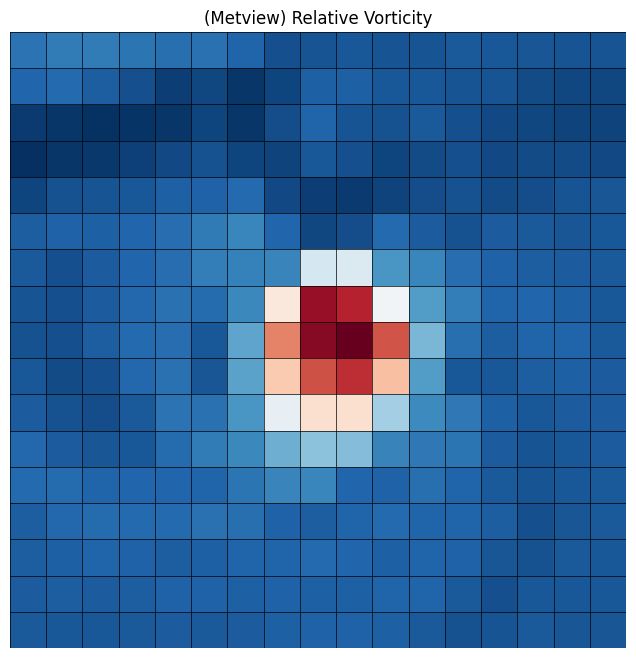

Neighborhood RV min (** 10^-5 / s): -213.07815331965685
Neighborhood RV max (** 10^-5 / s): 17.040246166288853


In [235]:
import metview as mv
import xarray as xr
grbu_path = '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_ugrd_850_mb.grib2'
grbv_path ='/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_vgrd_850_mb.grib2'

grb = pygrib.open(grbu_path)[1]
lats,lons = grb.latlons()
res = grb['iDirectionIncrementInDegrees']

ug = mv.read(grbu_path)
vg = mv.read(grbv_path)

xu = ug.to_dataset()
xv = vg.to_dataset()
vort_fieldset = mv.vorticity(xu,xv)

vort_850 = vort_fieldset.to_dataset()['vo'].to_masked_array()
masked_vort_850 = vort_850

x = int((1/res)*(90-lat))
y = int((1/res)*(0+lon))

neighborhood_size = calculate_neighborhood_size(2, res)

#rv = masked_vort_850.filled()[0]
rv = vort_850
# Extract the neighborhood for the current candidate
x_min = x - neighborhood_size
x_max = x + neighborhood_size + 1
y_min = y - neighborhood_size
y_max = y + neighborhood_size + 1

in_bounds = ((x_min >= 0) and
    (x_max <= rv.shape[0]) and
    (y_min >= 0) and
    (y_max <= rv.shape[1]))

if in_bounds:
    # the normal case (not edges of array)
    neighborhood = rv[x_min:x_max, y_min:y_max]
else:
    # handle indices at the boundaries
    neighborhood = extract_2d_neighborhood(rv, (x, y), neighborhood_size)

#create_image(neighborhood, 'Positive | Negative Relative Vorticity')
create_image(neighborhood, '(Metview) Relative Vorticity', rv_to_sign = False)
# GEMPAK yields -213.1 (no further precision)
print("Neighborhood RV min (** 10^-5 / s):", neighborhood.min() * np.power(10.0,5))
print("Neighborhood RV max (** 10^-5 / s):", neighborhood.max() * np.power(10.0,5))

4
x,y 414 668


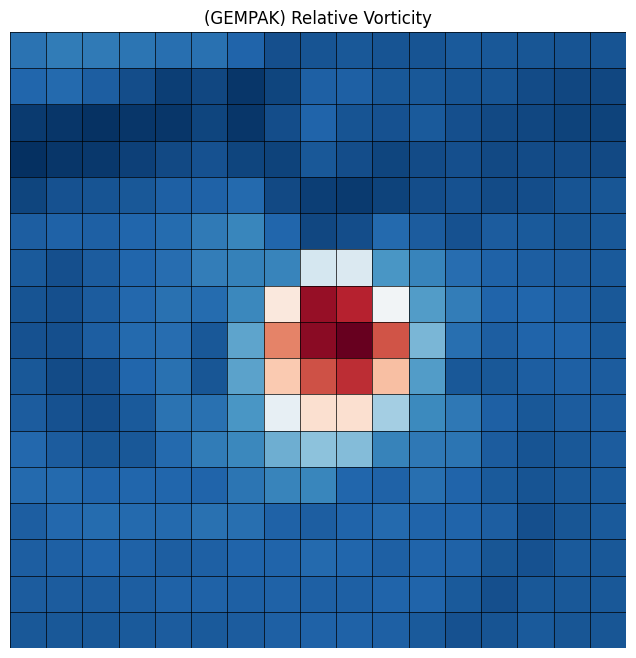

Neighborhood RV min (** 10^-5 / s): -213.1
Neighborhood RV max (** 10^-5 / s): 17.0


In [236]:
# since this is not a grib file have to set res manually
res = 0.25
gempak_out_var, scale = read_gdlist('/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_vor_850_mb.out')
out_var = gempak_out_var * 10**scale

gempack_vort = np.ma.masked_invalid(np.array(out_var))
vort_850 = gempack_vort

x = int((1/res)*(90-lat))
y = int((1/res)*(0+lon))
print('x,y',x,y)

neighborhood_size = calculate_neighborhood_size(2, res)

#rv = masked_vort_850.filled()[0]
rv = vort_850
# Extract the neighborhood for the current candidate
x_min = x - neighborhood_size
x_max = x + neighborhood_size + 1
y_min = y - neighborhood_size
y_max = y + neighborhood_size + 1

in_bounds = ((x_min >= 0) and
    (x_max <= rv.shape[0]) and
    (y_min >= 0) and
    (y_max <= rv.shape[1]))

if in_bounds:
    # the normal case (not edges of array)
    neighborhood = rv[x_min:x_max, y_min:y_max]
else:
    # handle indices at the boundaries
    neighborhood = extract_2d_neighborhood(rv, (x, y), neighborhood_size)

#create_image(neighborhood, 'Positive | Negative Relative Vorticity')
create_image(neighborhood, '(GEMPAK) Relative Vorticity', rv_to_sign = False)
# GEMPAK yields -213.1 (no further precision)
print("Neighborhood RV min (** 10^-5 / s):", neighborhood.min() * np.power(10.0,5))
print("Neighborhood RV max (** 10^-5 / s):", neighborhood.max() * np.power(10.0,5))

x,y 153 334
lat/lon for x,y -13.5 167.0


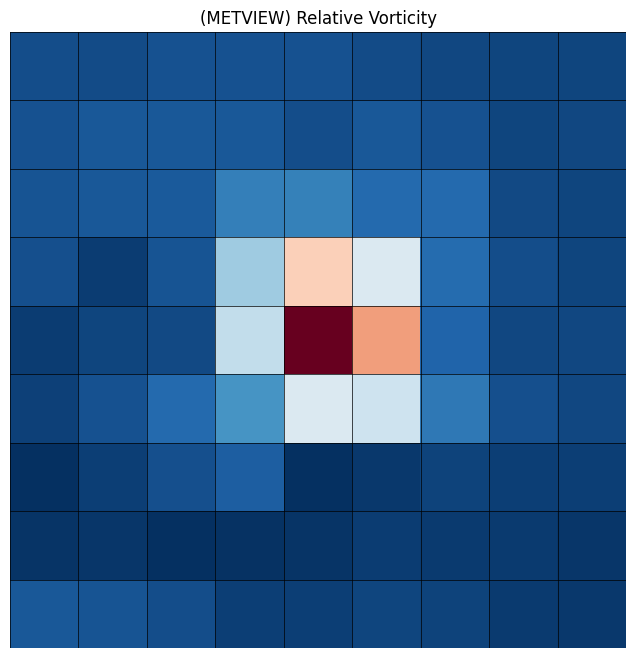

Neighborhood RV min (** 10^-5 / s): -168.7200041487813
Neighborhood RV max (** 10^-5 / s): 7.0299996878020465


In [237]:
import xarray as xr
import metview as mv

grb_vor_path = '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_vor_850_mb.grib2'

grb = pygrib.open(grb_vor_path)[1]
lats,lons = grb.latlons()
res = grb['iDirectionIncrementInDegrees']

xvor_850 = xr.open_dataset(grb_vor_path, engine="cfgrib",filter_by_keys={'typeOfLevel': 'isobaricInhPa'})

vor_fs = mv.read(grb_vor_path)

vort_850 = vor_fs.to_dataset()['vo'].to_masked_array()
masked_vort_850 = vort_850

# the lats's are placed in the other direction for this grib
x = int((1/res)*(90+lat))
y = int((1/res)*(0+lon))
print('x,y',x,y)
print('lat/lon for x,y', lats[x][y], lons[x,y])

neighborhood_size = calculate_neighborhood_size(2, res)

#rv = masked_vort_850.filled()[0]
rv = vort_850
# Extract the neighborhood for the current candidate
x_min = x - neighborhood_size
x_max = x + neighborhood_size + 1
y_min = y - neighborhood_size
y_max = y + neighborhood_size + 1

in_bounds = ((x_min >= 0) and
    (x_max <= rv.shape[0]) and
    (y_min >= 0) and
    (y_max <= rv.shape[1]))

if in_bounds:
    # the normal case (not edges of array)
    neighborhood = rv[x_min:x_max, y_min:y_max]
else:
    # handle indices at the boundaries
    neighborhood = extract_2d_neighborhood(rv, (x, y), neighborhood_size)

#create_image(neighborhood, 'Positive | Negative Relative Vorticity')
create_image(neighborhood, '(METVIEW) Relative Vorticity', rv_to_sign = False)
# GEMPAK yields: -168.72 (precision in grib set to 5 digits)
print("Neighborhood RV min (** 10^-5 / s):", neighborhood.min() * np.power(10.0,5))
print("Neighborhood RV max (** 10^-5 / s):", neighborhood.max() * np.power(10.0,5))

/home/db/.local/lib/python3.9/site-packages/cfgrib/xarray_to_grib.py:261: FutureWarning: GRIB write support is experimental, DO NOT RELY ON IT!
  warnings.warn("GRIB write support is experimental, DO NOT RELY ON IT!", FutureWarning)
/home/db/.local/lib/python3.9/site-packages/cfgrib/xarray_to_grib.py:261: FutureWarning: GRIB write support is experimental, DO NOT RELY ON IT!
  warnings.warn("GRIB write support is experimental, DO NOT RELY ON IT!", FutureWarning)


x,y 207 334
lat/lon for x,y -13.5 167.0


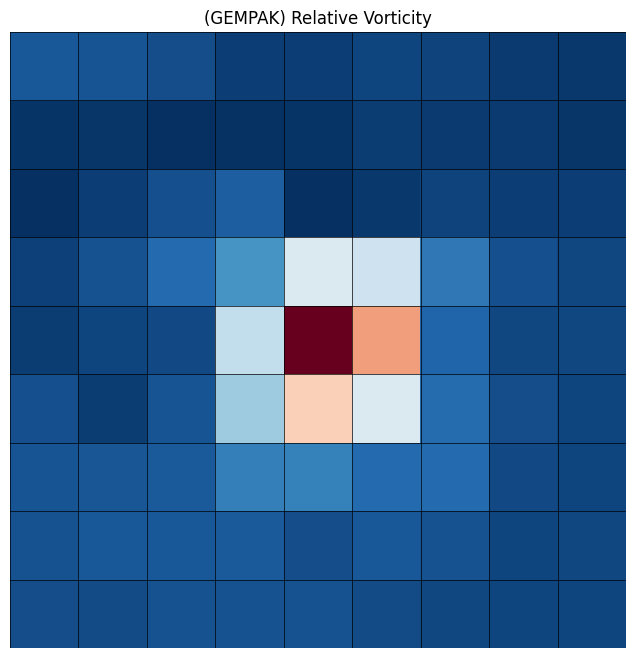

Neighborhood RV min (** 10^-5 / s): -168.72164560481906
Neighborhood RV max (** 10^-5 / s): 7.027329411357641


In [238]:
import xarray as xr
import metview as mv

grbu_path = '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_ugrd_850_mb.grib2'
grbv_path ='/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_vgrd_850_mb.grib2'

grb = pygrib.open(grbu_path)[1]
lats,lons = grb.latlons()
res = grb['iDirectionIncrementInDegrees']

xu_wind_850 = xr.open_dataset(grbu_path, engine="cfgrib",filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
xv_wind_850 = xr.open_dataset(grbv_path, engine="cfgrib",filter_by_keys={'typeOfLevel': 'isobaricInhPa'})

ug = mv.read(grbu_path)
vg = mv.read(grbv_path)

xu = ug.to_dataset()
xv = vg.to_dataset()
vort_fieldset = mv.vorticity(xu,xv)

vort_850 = vort_fieldset.to_dataset()['vo'].to_masked_array()
masked_vort_850 = vort_850

x = int((1/res)*(90-lat))
y = int((1/res)*(0+lon))
print('x,y', x,y)
print('lat/lon for x,y', lats[x][y], lons[x,y])
neighborhood_size = calculate_neighborhood_size(2, res)

#rv = masked_vort_850.filled()[0]
rv = vort_850
# Extract the neighborhood for the current candidate
x_min = x - neighborhood_size
x_max = x + neighborhood_size + 1
y_min = y - neighborhood_size
y_max = y + neighborhood_size + 1

in_bounds = ((x_min >= 0) and
    (x_max <= rv.shape[0]) and
    (y_min >= 0) and
    (y_max <= rv.shape[1]))

if in_bounds:
    # the normal case (not edges of array)
    neighborhood = rv[x_min:x_max, y_min:y_max]
else:
    # handle indices at the boundaries
    neighborhood = extract_2d_neighborhood(rv, (x, y), neighborhood_size)

#create_image(neighborhood, 'Positive | Negative Relative Vorticity')
create_image(neighborhood, '(GEMPAK) Relative Vorticity', rv_to_sign = False)
# GEMPAK yields: -168.72 (precision in grib set to 5 digits)
print("Neighborhood RV min (** 10^-5 / s):", neighborhood.min() * np.power(10.0,5))
print("Neighborhood RV max (** 10^-5 / s):", neighborhood.max() * np.power(10.0,5))

In [ ]:
##### TEST DB STORAGE/RETRIEVAL AND BULK STEP CALCULATIONS

In [466]:
model_name = 'GFS'
model_timestamp_str = '2023-10-30T06:00:00'
model_time_steps = [60, 66, 72]

model_timestamp = datetime.fromisoformat(model_timestamp_str)
all_candidates = calc_disturbances_by_model_name_date_and_time_steps(model_name, model_timestamp, model_time_steps)

Calculating disturbances (TC candidates) GFS for 20231030 06Z at +60h
load_and_extract_split_grib_data() execution time (seconds): 4.9
find_mslp_minima_with_closed_isobars() execution time (seconds): 11.4
Calculating Relative vorticity for 850 hPa


/home/db/.local/lib/python3.9/site-packages/pint/facets/plain/quantity.py:986: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


calculate_vorticity() execution time (seconds): 1.7
Finished calculating vorticity
add_basin_name() execution time (seconds): 0.9
find_rv_maximums_in_neighborhoods() execution time (seconds): 0.0
find_gp_250_850_max_thickness() execution time (seconds): 0.0
find_max_wind_925() execution time (seconds): 0.0
calc_disturbance_threshold_booleans() execution time (seconds): 0.0
Remove candidates not meeting all criteria execution time (seconds): 0.0


Total time taken for one step GFS execution time (seconds): 18.9


Calculating disturbances (TC candidates) GFS for 20231030 06Z at +66h
load_and_extract_split_grib_data() execution time (seconds): 4.2
find_mslp_minima_with_closed_isobars() execution time (seconds): 9.9
Calculating Relative vorticity for 850 hPa


/home/db/.local/lib/python3.9/site-packages/pint/facets/plain/quantity.py:986: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


calculate_vorticity() execution time (seconds): 1.7
Finished calculating vorticity
add_basin_name() execution time (seconds): 0.6
find_rv_maximums_in_neighborhoods() execution time (seconds): 0.0
find_gp_250_850_max_thickness() execution time (seconds): 0.0
find_max_wind_925() execution time (seconds): 0.0
calc_disturbance_threshold_booleans() execution time (seconds): 0.0
Remove candidates not meeting all criteria execution time (seconds): 0.0


Total time taken for one step GFS execution time (seconds): 16.5


Calculating disturbances (TC candidates) GFS for 20231030 06Z at +72h
load_and_extract_split_grib_data() execution time (seconds): 4.0
find_mslp_minima_with_closed_isobars() execution time (seconds): 10.0
Calculating Relative vorticity for 850 hPa


/home/db/.local/lib/python3.9/site-packages/pint/facets/plain/quantity.py:986: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


calculate_vorticity() execution time (seconds): 2.0
Finished calculating vorticity
add_basin_name() execution time (seconds): 0.6
find_rv_maximums_in_neighborhoods() execution time (seconds): 0.0
find_gp_250_850_max_thickness() execution time (seconds): 0.0
find_max_wind_925() execution time (seconds): 0.0
calc_disturbance_threshold_booleans() execution time (seconds): 0.0
Remove candidates not meeting all criteria execution time (seconds): 0.0


Total time taken for one step GFS execution time (seconds): 16.6


Total time taken for all steps GFS execution time (seconds): 52.0


In [474]:
model_name = "GFS"
model_timestamp_str = '2023-10-30T06:00:00'
time_steps = [60, 66, 72]

model_timestamp = datetime.fromisoformat(model_timestamp_str)
disturbance_candidates = get_disturbances_from_db(model_name, model_timestamp)
for time_step in time_steps:
    time_step_str = str(time_step)
    print("============================================")
    print("DISTURBANCES MEETING TC CRITERIA")
    print(f"{model_name} {model_timestamp} +{time_step_str}h")
    print("============================================")
    if disturbance_candidates:
        if time_step_str in disturbance_candidates:
            print_candidates(disturbance_candidates[time_step_str])
    print("")

DISTURBANCES MEETING TC CRITERIA
GFS 2023-10-30 06:00:00 +60h
# 1, EP Basin, Latitude (deg:):   12.0, Longitude (deg):  -89.2, MSLP (hPa): 1003.6
        850 RV MAX (*10^-5 1/s):  93.18, 250-850 hPa Thickness (m): 9529.41, 925 hPa WS MAX (m/s):  26.36

DISTURBANCES MEETING TC CRITERIA
GFS 2023-10-30 06:00:00 +66h
# 1, AL Basin, Latitude (deg:):   14.8, Longitude (deg):  -70.0, MSLP (hPa): 1006.0
        850 RV MAX (*10^-5 1/s):  66.15, 250-850 hPa Thickness (m): 9549.08, 925 hPa WS MAX (m/s):  17.76
# 2, AL Basin, Latitude (deg:):   14.8, Longitude (deg):  -69.2, MSLP (hPa): 1005.4
        850 RV MAX (*10^-5 1/s):  66.15, 250-850 hPa Thickness (m): 9549.08, 925 hPa WS MAX (m/s):  17.76
# 3, AL Basin, Latitude (deg:):   14.2, Longitude (deg):  -69.0, MSLP (hPa): 1000.2
        850 RV MAX (*10^-5 1/s):  66.15, 250-850 hPa Thickness (m): 9549.08, 925 hPa WS MAX (m/s):  17.76
# 4, EP Basin, Latitude (deg:):   11.5, Longitude (deg):  -89.8, MSLP (hPa): 1004.2
        850 RV MAX (*10^-5 1/s)

In [151]:
# do an entire run
model_name = "GFS"
model_timestamp_str = '2023-10-31T12:00:00'
model_timestamp = datetime.fromisoformat(model_timestamp_str)
model_hour_str = f'{model_timestamp.hour:02}'
time_steps = all_time_steps_by_model['GFS'][model_hour_str]

model_timestamp = datetime.fromisoformat(model_timestamp_str)
all_candidates = calc_disturbances_by_model_name_date_and_time_steps(model_name, model_timestamp, time_steps)

Total time taken for all steps GFS execution time (seconds): 0.0


In [ ]:
#1054.1 for 00Z
#969.9 for 06Z

In [78]:
# list an entire run
model_name = "GFS"
model_timestamp_str = '2023-10-31T12:00:00'
model_timestamp = datetime.fromisoformat(model_timestamp_str)
time_steps = all_time_steps_by_model[model_name]
generate_disturbances_chart(model_name, model_timestamp, time_steps)

/home/db/.local/lib/python3.9/site-packages/ipyleaflet/leaflet.py:2073: DeprecationWarning: the name argument is deprecated, use title instead
  warnings.warn("the name argument is deprecated, use title instead", DeprecationWarning)


Map(center=[0, 200], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…